In [13]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, Concatenate, TimeDistributed,
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization,
    MultiHeadAttention, LayerNormalization, Add
)
from tensorflow.keras.applications import VGG16
from sklearn.preprocessing import MinMaxScaler
import optuna
import os
import matplotlib.pyplot as plt

In [6]:

# Funciones
# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def get_closest_image_path(timestamp, image_folder):
    base_image_name = f'OR_ABI-L2-ACMF-M6_G16_s{timestamp.strftime("%Y%m%d%H%M")}'
    for second in range(60):
        image_name = f"{base_image_name}{second:02d}.png"
        image_path = os.path.join(image_folder, image_name)
        if os.path.exists(image_path):
            return image_path
    return None



def calculate_fourier_features(series, n_components=5):
    fft = np.fft.fft(series)
    fft_magnitudes = np.abs(fft)[:len(fft) // 2]  # Usar solo frecuencias positivas
    top_frequencies = np.argsort(fft_magnitudes)[-n_components:]  # Seleccionar las más importantes
    top_magnitudes = fft_magnitudes[top_frequencies]
    
    # Asegurarse de que `top_magnitudes` siempre tenga longitud `n_components`
    if len(top_magnitudes) < n_components:
        # Si hay menos componentes, rellenar con ceros
        padding = np.zeros(n_components - len(top_magnitudes))
        top_magnitudes = np.concatenate([top_magnitudes, padding])
    
    return top_magnitudes


def load_images_and_ghi(df_filtrado, image_folder, n_fourier=5):
    images = []
    ghi_values = []
    doy_sin = []
    doy_cos = []
    hour_sin = []
    hour_cos = []
    fourier_features = []

    # Inicializar la última imagen válida con una imagen de ceros por si es la primera vez
    last_valid_image = np.zeros((64, 64, 3), dtype=np.uint8)

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        doy_sin_value = row['DoY Sin']
        doy_cos_value = row['DoY Cos']

        # Calcular seno y coseno de la hora del día
        hour_fraction = timestamp.hour + timestamp.minute / 60.0
        hour_sin_value = np.sin(2 * np.pi * hour_fraction / 24)
        hour_cos_value = np.cos(2 * np.pi * hour_fraction / 24)

        image_path = get_closest_image_path(timestamp, image_folder)
        img = cv2.imread(image_path)

        if img is not None:
            # Procesar la imagen si está disponible
            img_resized = cv2.resize(img, (64, 64))
            img_preprocessed = tf.keras.applications.vgg16.preprocess_input(img_resized)
            last_valid_image = img_preprocessed  # Actualizar la última imagen válida
        else:
            # Usar la última imagen válida (Forward Fill)
            img_preprocessed = last_valid_image
            print(f"Imagen no encontrada: {image_path}, usando la última imagen válida.")

        # Agregar valores a las listas
        images.append(img_preprocessed)
        ghi_values.append(ghi_value)
        doy_sin.append(doy_sin_value)
        doy_cos.append(doy_cos_value)
        hour_sin.append(hour_sin_value)
        hour_cos.append(hour_cos_value)

        # Calcular componentes de Fourier para GHI
        if len(ghi_values) >= n_fourier:
            fourier_comp = calculate_fourier_features(ghi_values[-n_fourier:], n_components=n_fourier)
        else:
            fourier_comp = np.zeros(n_fourier)  # Rellenar con ceros si no hay suficientes datos

        fourier_features.append(fourier_comp)

    # Convertir a numpy arrays, asegurando consistencia en las dimensiones
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)

    doy_sin = np.array(doy_sin).reshape(-1, 1)
    doy_cos = np.array(doy_cos).reshape(-1, 1)
    hour_sin = np.array(hour_sin).reshape(-1, 1)
    hour_cos = np.array(hour_cos).reshape(-1, 1)

    print(f"doy_sin_train shape: {doy_sin.shape}")
    print(f"doy_cos_train shape: {doy_cos.shape}")
    print(f"hour_sin_train shape: {hour_sin.shape}")
    print(f"hour_cos_train shape: {hour_cos.shape}")
    print(f"fourier_features_train shape: {len(fourier_features)}")
    # Convertir fourier_features en numpy array de forma consistente
    fourier_features = np.array(fourier_features)

    return np.array(images), ghi_values_scaled, scaler, doy_sin, doy_cos, hour_sin, hour_cos, fourier_features


# Preparar secuencias para la LSTM
def create_sequences(images, aux_features, ghi_values, time_steps):
    X_images_seq = []
    X_aux_seq = []
    y_seq = []

    for i in range(len(images) - time_steps):
        # Crear secuencia de imágenes de longitud `time_steps`
        X_images_seq.append(images[i:i + time_steps])
        
        # Crear secuencia de características auxiliares de longitud `time_steps`
        X_aux_seq.append(aux_features[i:i + time_steps])
        
        # La variable objetivo es una secuencia de `n_steps` valores GHI después del último paso de la secuencia
        y_seq.append(ghi_values[i + time_steps])

    return np.array(X_images_seq), np.array(X_aux_seq), np.array(y_seq)



In [ ]:
def build_model_with_transformer(trial, time_steps, aux_features_shape):
    # Hiperparámetros
    dense_units = trial.suggest_int("dense_units", 64, 256, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5, step=0.1)
    num_heads = trial.suggest_int("num_heads", 2, 8, step=2)
    ff_dim = trial.suggest_int("ff_dim", 64, 256, step=64)

    # Submodelo para imágenes (CNN con VGG16 preentrenado)
    vgg16 = VGG16(include_top=False, input_shape=(64, 64, 3))
    for layer in vgg16.layers:
        layer.trainable = False  # Congela las capas preentrenadas

    cnn_model = tf.keras.Sequential([
        vgg16,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate)
    ])

    image_input = Input(shape=(time_steps, 64, 64, 3))
    processed_images = TimeDistributed(cnn_model)(image_input)

    # Transformer para secuencias de imágenes
    def transformer_block(inputs, num_heads, ff_dim, dropout_rate):
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
        attention_output = Dropout(dropout_rate)(attention_output)
        add_attention = Add()([inputs, attention_output])
        attention_output = LayerNormalization()(add_attention)

        ffn_output = Dense(ff_dim, activation="relu")(attention_output)
        ffn_output = Dense(inputs.shape[-1])(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        add_ffn = Add()([attention_output, ffn_output])
        ffn_output = LayerNormalization()(add_ffn)

        return ffn_output

    transformer_output = transformer_block(processed_images, num_heads, ff_dim, dropout_rate)
    transformer_output = Flatten()(transformer_output)

    # Submodelo para características auxiliares
    aux_input = Input(shape=(time_steps, aux_features_shape))
    aux_dense = TimeDistributed(Dense(128, activation="relu"))(aux_input)
    aux_dense = Flatten()(aux_dense)

    # Combinar salidas de CNN-Transformer y características auxiliares
    combined = Concatenate()([transformer_output, aux_dense])

    # Capas densas finales
    dense_out = Dense(dense_units, activation='relu')(combined)
    dense_out = Dropout(dropout_rate)(dense_out)
    final_output = Dense(1, activation='linear')(dense_out)

    # Modelo completo
    model = Model(inputs=[image_input, aux_input], outputs=final_output)
    model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])
    return model


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@269.458] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@272.082] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@274.709] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@274.771] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@275.663] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@277.327] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@277.389] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


[I 2024-11-29 18:48:30,878] A new study created in memory with name: no-name-78d1105d-15dc-47bc-b371-27f20352093e
I0000 00:00:1732924110.890748 1778367 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-29 18:48:30.890988: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_24'

Best trial:
  Value: 0.00317977461963892
  Params: 
    dense_units: 192
    dropout_rate: 0.5
    num_heads: 2
    ff_dim: 256


In [15]:

#Datos
df = pd.read_pickle('/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/df_GHI.plk')

    # Filtrar datos
fecha_inicio_entrenamiento = '2023-01-01 05:00:00'
fecha_fin_entrenamiento = '2023-02-28 18:30:00'

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_entrenamiento = df[(df['Timestamp'] >= fecha_inicio_entrenamiento) & (df['Timestamp'] <= fecha_fin_entrenamiento)]

image_folder = '/home/aia-workstation/Documents/Santiago/Modelo/Cloud_Forecasting_CNN_LSTM/Images/ACMF'
X_images_train, y_ghi_train, scaler_train, doy_sin_train, doy_cos_train,hour_sin, hour_cos, fourier_features_train = load_images_and_ghi(df_entrenamiento, image_folder)

X_aux_features_train = np.concatenate([doy_sin_train, doy_cos_train,hour_sin,hour_cos, fourier_features_train], axis=1)
time_steps = 12
X_images_train_seq, X_aux_train_seq, y_train_seq = create_sequences(X_images_train, X_aux_features_train, y_ghi_train, time_steps)


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@46836.958] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@46840.122] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@46842.874] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@46842.936] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@46843.839] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@46845.519] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@46845.582] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (4838, 1)
doy_cos_train shape: (4838, 1)
hour_sin_train shape: (4838, 1)
hour_cos_train shape: (4838, 1)
fourier_features_train shape: 4838


In [ ]:

# Función objetivo para Optuna
def objective(trial):


    model = build_model_with_transformer(trial, time_steps, X_aux_features_train.shape[1])

    history = model.fit(
        [X_images_train_seq, X_aux_train_seq],
        y_train_seq,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    val_loss = history.history['val_loss'][-1]
    return val_loss


# Ejecución de Optuna
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)

    # Mejor conjunto de hiperparámetros
    print("Best trial:")
    trial = study.best_trial

    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


In [16]:


# Submodelo para imágenes (CNN con VGG16 preentrenado)
vgg16 = VGG16(include_top=False, input_shape=(64, 64, 3))
for layer in vgg16.layers:
    layer.trainable = False  # Congela las capas preentrenadas

cnn_model = tf.keras.Sequential([
    vgg16,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(study.best_params['dropout_rate'])
    ])

image_input = Input(shape=(time_steps, 64, 64, 3))
processed_images = TimeDistributed(cnn_model)(image_input)

    # Transformer para secuencias de imágenes
def transformer_block(inputs, num_heads, ff_dim, dropout_rate):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    add_attention = Add()([inputs, attention_output])
    attention_output = LayerNormalization()(add_attention)

    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    add_ffn = Add()([attention_output, ffn_output])
    ffn_output = LayerNormalization()(add_ffn)
    return ffn_output
transformer_output = transformer_block(processed_images, study.best_params['num_heads'], study.best_params['ff_dim'], study.best_params['dropout_rate'])
transformer_output = Flatten()(transformer_output)

    # Submodelo para características auxiliares
aux_input = Input(shape=(time_steps, X_aux_features_train.shape[1]))
aux_dense = TimeDistributed(Dense(128, activation="relu"))(aux_input)
aux_dense = Flatten()(aux_dense)

    # Combinar salidas de CNN-Transformer y características auxiliares
combined = Concatenate()([transformer_output, aux_dense])

    # Capas densas finales
dense_out = Dense(study.best_params['dense_units'], activation='relu')(combined)
dense_out = Dropout(study.best_params['dropout_rate'])(dense_out)
final_output = Dense(1, activation='linear')(dense_out)

    # Modelo completo
model = Model(inputs=[image_input, aux_input], outputs=final_output)
model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])

model.fit([X_images_train_seq, X_aux_train_seq], y_train_seq, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


/home/aia-workstation/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_969', 'keras_tensor_983']. Received: the structure of inputs=('*', '*')
  warnings.warn(


121/121 ━━━━━━━━━━━━━━━━━━━━ 87s 685ms/step - loss: 7.1432 - mae: 0.8980 - val_loss: 0.0142 - val_mae: 0.0985
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 678ms/step - loss: 0.0393 - mae: 0.1442 - val_loss: 0.3750 - val_mae: 0.6055
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 681ms/step - loss: 0.0488 - mae: 0.1457 - val_loss: 0.0085 - val_mae: 0.0634
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 681ms/step - loss: 0.0212 - mae: 0.1070 - val_loss: 0.0042 - val_mae: 0.0368
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 682ms/step - loss: 0.0188 - mae: 0.1006 - val_loss: 0.0049 - val_mae: 0.0473
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 83s 682ms/step - loss: 0.0167 - mae: 0.0976 - val_loss: 0.0202 - val_mae: 0.1248
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 682ms/step - loss: 0.0168 - mae: 0.0976 - val_loss: 0.0043 - val_mae: 0.0373
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 83s 683ms/step - loss: 0.0149 - mae: 0.0921 - val_loss: 0.0052 - val_mae: 0.0465
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 83s

Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@52042.409] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.
Imagen no encontrada: None, usando la última imagen válida.


[ WARN:0@52042.833] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@52042.850] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@52042.850] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@52042.854] global loadsave.cpp:241 findDecoder imread_(''): can't open/read file: check file path/integrity


doy_sin_train shape: (1227, 1)
doy_cos_train shape: (1227, 1)
hour_sin_train shape: (1227, 1)
hour_cos_train shape: (1227, 1)
fourier_features_train shape: 1227
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 542ms/step
MAE en el conjunto de prueba: 0.18971844577001246
RMSE en el conjunto de prueba: 0.23931559901915678


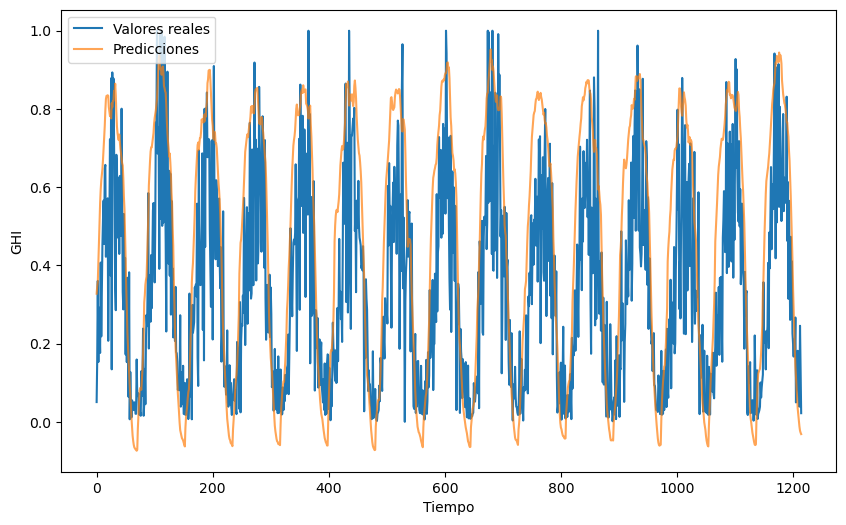

In [18]:
# Probar el modelo
# Preparar el conjunto de prueba
fecha_inicio_prueba = '2023-03-15 05:00:00'  # Fecha de inicio de prueba
fecha_fin_prueba = '2023-03-29 18:00:00'  # Fecha de fin de prueba

# Filtrar el DataFrame por el rango de prueba
df_prueba = df[(df['Timestamp'] >= fecha_inicio_prueba) & (df['Timestamp'] <= fecha_fin_prueba)]

# Cargar imágenes y valores GHI para el conjunto de prueba
X_images_test, y_ghi_test, scaler_test, doy_sin_test, doy_cos_test, hour_sin_train,hour_cos_train, fourier_features_train = load_images_and_ghi(df_prueba, image_folder)

# Concatenar DOY sin y cos con las imágenes de prueba
X_aux_features_test = np.concatenate([doy_sin_test, doy_cos_test,hour_sin_train,hour_cos_train,fourier_features_train], axis=1)

# Crear las secuencias de prueba con time_steps = 6
X_images_test_seq, X_aux_test_seq, y_test_seq = create_sequences(X_images_test, X_aux_features_test, y_ghi_test, time_steps)

# Hacer predicciones
y_pred = model.predict([X_images_test_seq, X_aux_test_seq])

# Invertir la normalización para GHI
y_test_seq_inversed = scaler_test.inverse_transform(y_test_seq)
y_pred_inversed = scaler_test.inverse_transform(y_pred)

# Evaluar el modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_seq_inversed, y_pred_inversed)
rmse = np.sqrt(mean_squared_error(y_test_seq_inversed, y_pred_inversed))

print(f'MAE en el conjunto de prueba: {mae}')
print(f'RMSE en el conjunto de prueba: {rmse}')

# Visualizar algunas predicciones
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq_inversed, label='Valores reales')
plt.plot(y_pred_inversed, label='Predicciones', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('GHI')
plt.legend()
plt.show()